In [1]:
from nsepy import get_history
from tqdm.notebook import tqdm
import os
import pandas as pd
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from lib import util

# pd.options.display.float_format = '{:.4%}'.format

listed_companies = util.get_merged_market_sector_data()
merged = util.get_close_values_for_topn(listed_companies, 150)
merged = util.merge_data_with_index(merged)
sectors = listed_companies.Sector
Y_all = merged.ffill().pct_change().dropna()
index = 'NIFTY 50'
Y = Y_all[[col for col in Y_all.columns if col != index]]
Y_index = Y_all[[index]]
asset_classes = util.get_industry_for_assets(Y.columns.tolist(), listed_companies)

In [2]:
row_df = pd.DataFrame(
            [[0.0]*len(Y_index.columns)], \
            columns=Y_index.columns, \
            index=[Y_index.index.min() + pd.Timedelta(-1, unit='D')])
Y_index_plot = pd.concat([row_df, Y_index])
Y_index_plot = (Y_index_plot + 1).cumprod()

In [3]:
import riskfolio.Portfolio as pf

# Building the portfolio object
port = pf.Portfolio(returns=Y)
# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

port.kindbench = False # True if you have benchmark weights, False if you have an index
port.benchindex = Y_index # Index Returns
port.allowTE = True # Allows to use Tracking Error Constraints
port.TE = 0.008 # Maximum Tracking Error respect to benchmark returns

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'UCI' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

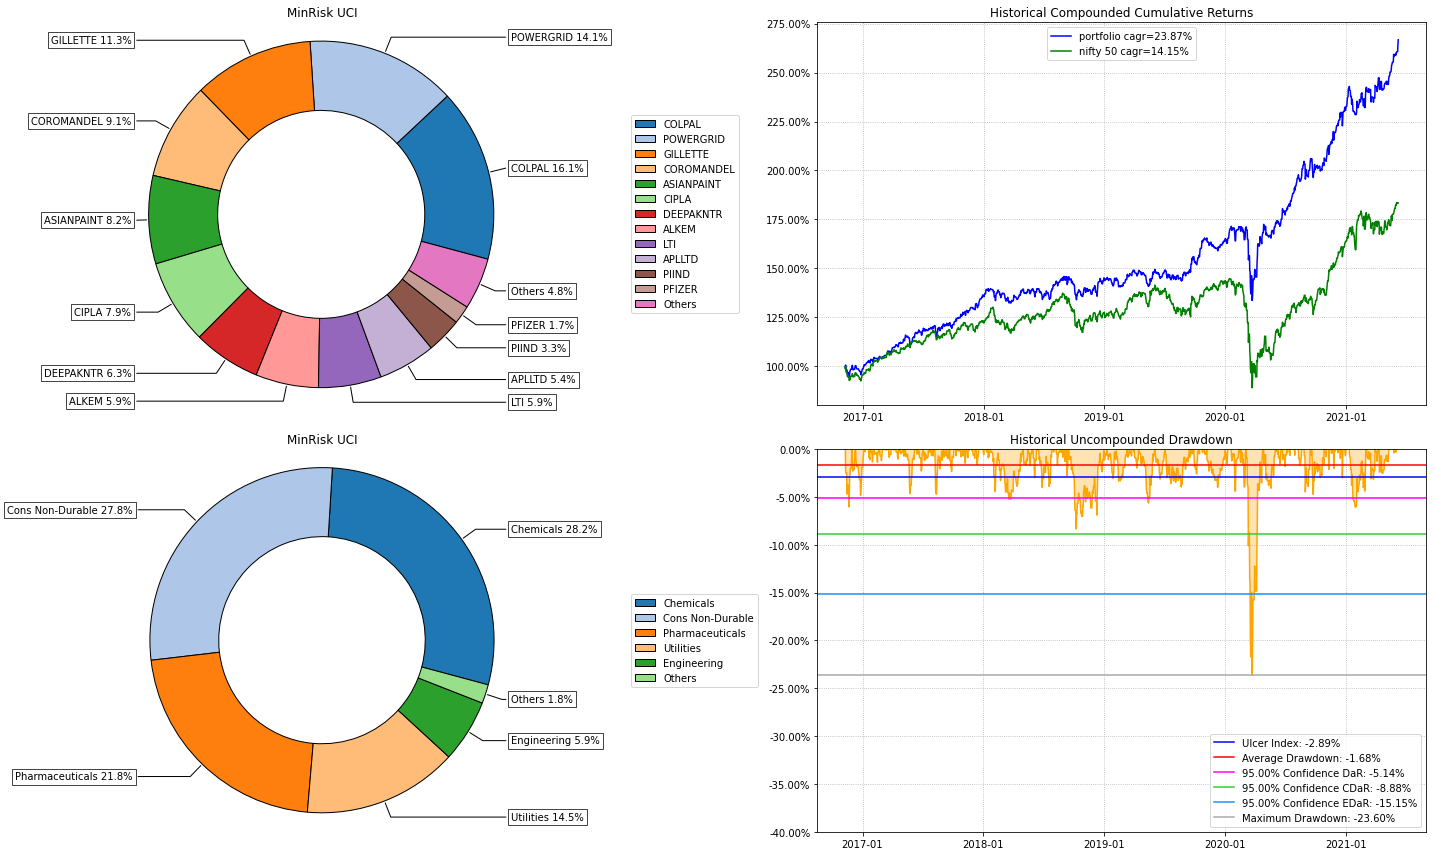

In [4]:
import riskfolio.PlotFunctions as plf
from matplotlib import pyplot

# Plotting the composition of the portfolio

fig, axis = pyplot.subplots(nrows=2, ncols=2, figsize=(20, 12))
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1).groupby(['Industry']).sum()

plf.plot_pie(w=w, title=f'{obj} {rm}', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=axis[0][0])
plf.plot_drawdown(nav=port.nav, w=w, alpha=0.05, height=6, width=10, ax=(axis[0][1], axis[1][1]))
plf.plot_pie(w=w_classes, title=f'{obj} {rm}', others=0.05, nrow=25,
                  cmap = "tab20", height=6, width=10, ax=axis[1][0])


index_cagr = util.get_cagr(Y_index)
port_cagr = util.get_cagr_portfolio(port.nav, w)

axis[0][1].plot_date(Y_index_plot.index.tolist(), Y_index_plot, "-", color='green', \
                     label=f'nifty 50 cagr={index_cagr*100:.2f}%')
axis[0][1].get_lines()[0].set_label(f'portfolio cagr={port_cagr*100:.2f}%')
axis[0][1].legend(loc ='upper center')


In [5]:
# points = 50 # Number of points of the frontier

# frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

# display(frontier.T.head())

In [6]:
# Plotting the efficient frontier

# label = 'MinRisk Adjusted Return Portfolio' # Title of point
# mu = port.mu # Expected returns
# cov = port.cov # Covariance matrix
# returns = port.returns # Returns of the assets

# ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
#                        rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
#                        marker='*', s=16, c='r', height=6, width=10, ax=None)

In [7]:
# import riskfolio.Reports as rp

# returns = port.returns

# ax = rp.jupyter_report(returns,
#                        w,
#                        rm=rm,
#                        rf=0,
#                        alpha=0.05,
#                        others=0.05,
#                        nrow=25,
#                        height=6,
#                        width=14,
#                        t_factor=252,
#                        ini_days=1,
#                        days_per_year=252,
#                        bins=50,
#                        )

In [8]:
import riskfolio.ConstraintsFunctions as cf

interested_industries = ['Technology', 'Pharmaceuticals', 'Oil & Gas', 'Automotive', 'Metals & Mining', \
                         'Telecom',  'Chemicals' , 'Manufacturing', \
                         'Conglomerates', 'Engineering', 'Cement/Construction',  \
                         'Services', 'Utilities', \
                         'Media', 'Tobacco']
# probs = np.linspace(0.1, 1, len(interested_industries))
# probs /= sum(probs)
# probs = probs[::-1].tolist()

probs = [0.3]*len(interested_industries)

not_interested_industeres = list(set(sectors) - set(interested_industries))

len_all_industries = len(interested_industries)+len(not_interested_industeres)

constraints = {'Disabled': [False] + [False] * len(interested_industries) + [False]* len(not_interested_industeres),
               'Type': ['All Assets'] + ['Classes'] * len_all_industries,
               'Set': [''] + ['Industry'] * len_all_industries,
               'Position': [''] + interested_industries + not_interested_industeres,
               'Sign': ['<='] * (len(interested_industries) + 1) + ['<='] * len(not_interested_industeres),
               'Weight': [0.5] + probs + [0] * len(not_interested_industeres),
               'Type Relative': [''] * (len_all_industries + 1),
               'Relative Set': [''] * (len_all_industries + 1),
               'Relative': [''] * (len_all_industries + 1),
               'Factor': [''] * (len_all_industries + 1)}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,0.5,,,,
1,False,Classes,Industry,Technology,<=,0.3,,,,
2,False,Classes,Industry,Pharmaceuticals,<=,0.3,,,,
3,False,Classes,Industry,Oil & Gas,<=,0.3,,,,
4,False,Classes,Industry,Automotive,<=,0.3,,,,
5,False,Classes,Industry,Metals & Mining,<=,0.3,,,,
6,False,Classes,Industry,Telecom,<=,0.3,,,,
7,False,Classes,Industry,Chemicals,<=,0.3,,,,
8,False,Classes,Industry,Manufacturing,<=,0.3,,,,
9,False,Classes,Industry,Conglomerates,<=,0.3,,,,


In [9]:
A, B = cf.assets_constraints(constraints, asset_classes)
port = pf.Portfolio(returns=Y)
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
port.ainequality = A
port.binequality = B
port.kindbench = False # True if you have benchmark weights, False if you have an index
port.benchindex = Y_index # Index Returns
port.allowTE = True # Allows to use Tracking Error Constraints
port.TE = 0.008 # Maximum Tracking Error respect to benchmark returns
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
display(w.T)

,RELIANCE,HDFCBANK,INFY,ICICIBANK,KOTAKBANK,BAJFINANCE,BHARTIARTL,ITC,HCLTECH,ASIANPAINT,...,OBEROIRLTY,PFIZER,ENDURANCE,TORNTPOWER,ZEEL,AIAENG,GILLETTE,TATACHEM,APLLTD,SUNTV
weights,1.189074e-10,2.120376e-10,1.609641e-10,1.655987e-10,1.463470e-10,6.482440e-11,2.407642e-10,0.000658,6.942957e-11,0.173307,...,4.538157e-11,0.024527,2.284546e-10,0.042262,1.998728e-12,3.575669e-11,5.365026e-11,3.284184e-10,1.154497e-10,1.319890e-10


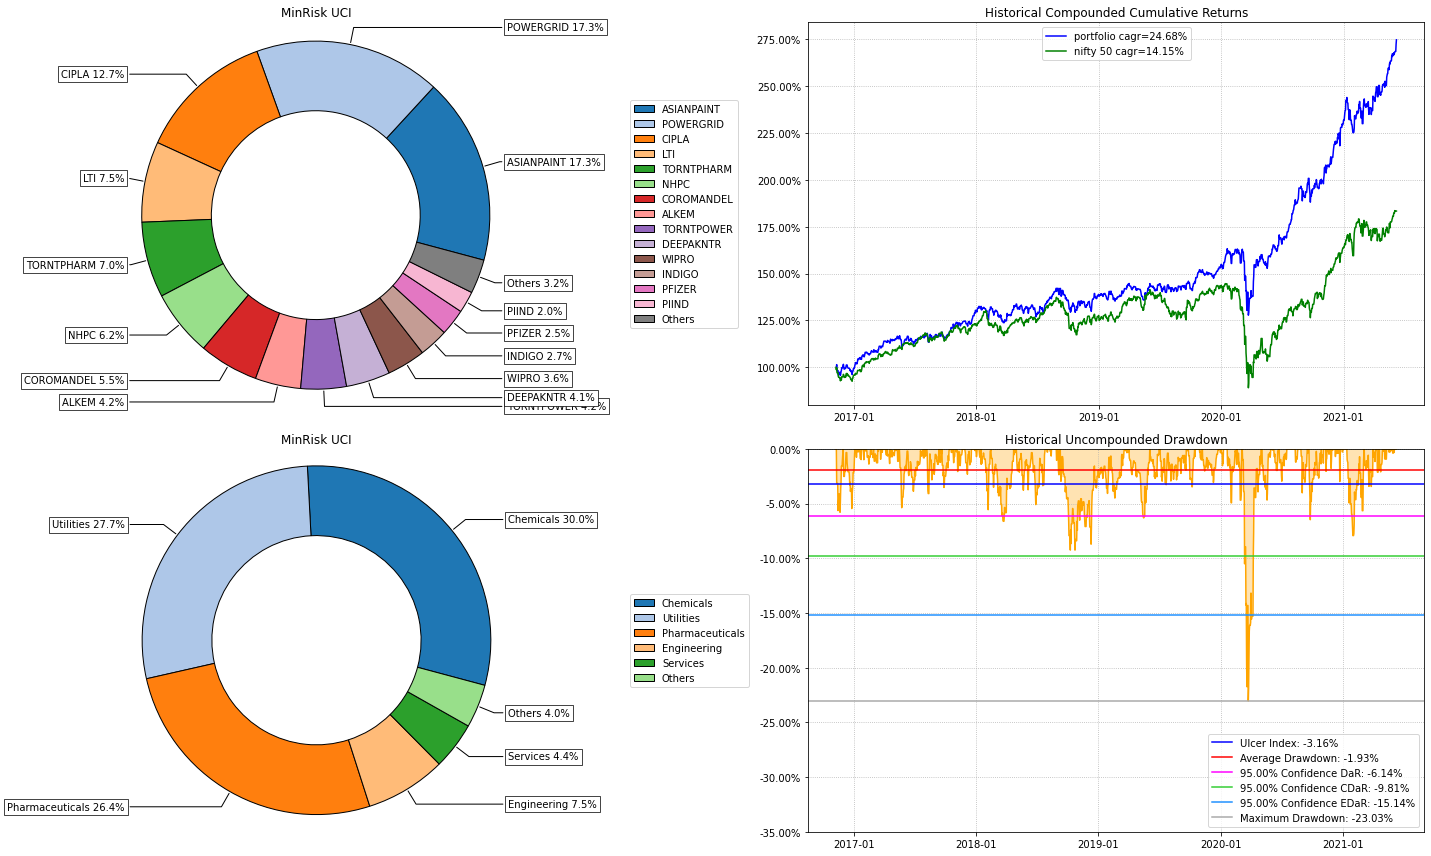

In [10]:
import riskfolio.PlotFunctions as plf
from matplotlib import pyplot

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1).groupby(['Industry']).sum()

# Plotting the composition of the portfolio

fig, axis = pyplot.subplots(nrows=2, ncols=2, figsize=(20, 12))
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1).groupby(['Industry']).sum()

plf.plot_pie(w=w, title=f'{obj} {rm}', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=axis[0][0])
plf.plot_drawdown(nav=port.nav, w=w, alpha=0.05, height=6, width=10, ax=(axis[0][1], axis[1][1]))
plf.plot_pie(w=w_classes, title=f'{obj} {rm}', others=0.05, nrow=25,
                  cmap = "tab20", height=6, width=10, ax=axis[1][0])

index_cagr = util.get_cagr(Y_index)
port_cagr = util.get_cagr_portfolio(port.nav, w)
axis[0][1].plot_date(Y_index_plot.index.tolist(), Y_index_plot, "-", color='green', \
                     label=f'nifty 50 cagr={index_cagr*100:.2f}%')
axis[0][1].get_lines()[0].set_label(f'portfolio cagr={port_cagr*100:.2f}%')
axis[0][1].legend(loc ='upper center')


In [11]:
# import riskfolio.Reports as rp

# returns = port.returns

# ax = rp.jupyter_report(returns,
#                        w,
#                        rm=rm,
#                        rf=0,
#                        alpha=0.05,
#                        others=0.05,
#                        nrow=25,
#                        height=6,
#                        width=14,
#                        t_factor=252,
#                        ini_days=1,
#                        days_per_year=252,
#                        bins=50,
#                        )